### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
#from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBSBSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(50)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12351
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|     2|[80 54 90 55 00 5...|1908.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    25|[00 CF F0 56 90 5...|1909.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    29|[80 C9 00 7E 00 7...|1910.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    37|[00 7E 00 7E 80 4...|1911.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    40|[E0 D5 00 7E E0 D...|1912.0|SBBBSBSS|
|    885.4| 47.3389|-108.4983|       TMAX|USC00248498|    18|[E0 50 40 52 

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00242886')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00242886'
16 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    11|[E0 D5 E0 50 90 D...|1913.0|SBBBSBSS|
|   1495.0| 46.6167|  -110.35|       TOBS|USC00242886|    11|[00 CF 20 50 00 0...|1914.0|SBBBSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



In [8]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT count(year) as year_cnt,station FROM weather\n\tWHERE measurement='%s' GROUP BY station ORDER BY year_cnt DESC"%('TOBS') 
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(50)

SELECT count(year) as year_cnt,station FROM weather
	WHERE measurement='TOBS' GROUP BY station ORDER BY year_cnt DESC
68 rows
+--------+-----------+
|year_cnt|    station|
+--------+-----------+
|      92|USC00243013|
|      84|USC00245596|
|      82|USC00247214|
|      82|USC00249033|
|      77|USC00244522|
|      73|USC00243727|
|      63|USC00247228|
|      62|USC00244007|
|      55|USC00243445|
|      55|USC00245387|
|      55|USC00242347|
|      54|USC00245761|
|      53|USC00243939|
|      50|USC00244954|
|      48|USC00248927|
|      47|USC00247263|
|      47|USC00244386|
|      42|USC00244545|
|      41|USC00246902|
|      41|USC00247864|
|      37|USC00247540|
|      37|USC00246008|
|      36|USC00243455|
|      35|USC00247858|
|      34|USW00024036|
|      33|USC00248498|
|      33|USC00245872|
|      32|USC00245235|
|      31|USC00244368|
|      28|USC00247234|
|      27|USC00248930|
|      25|USC00248495|
|      22|USC00245873|
|      21|USC00244384|
|      19|USC00248161|


### Script for plotting yearly plots

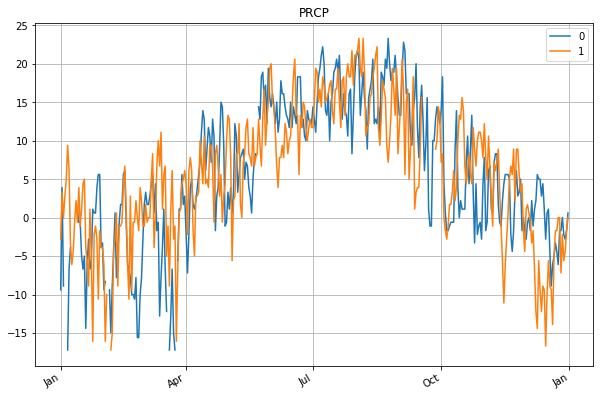

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [4]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/ramkishore31/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


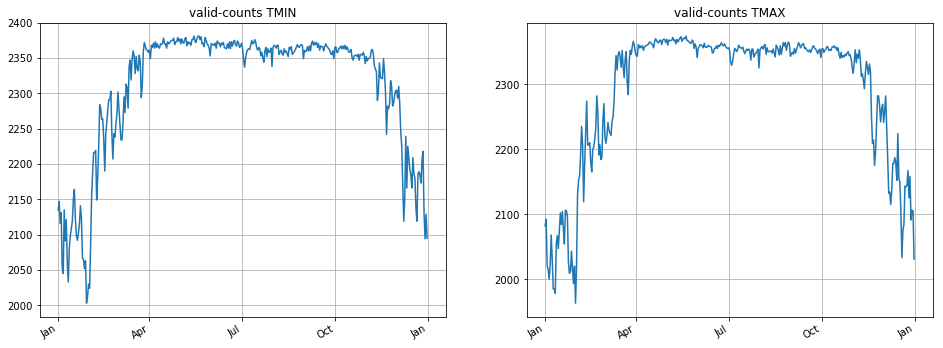

In [5]:
plot_pair(['TMIN','TMAX'],plot_valid)

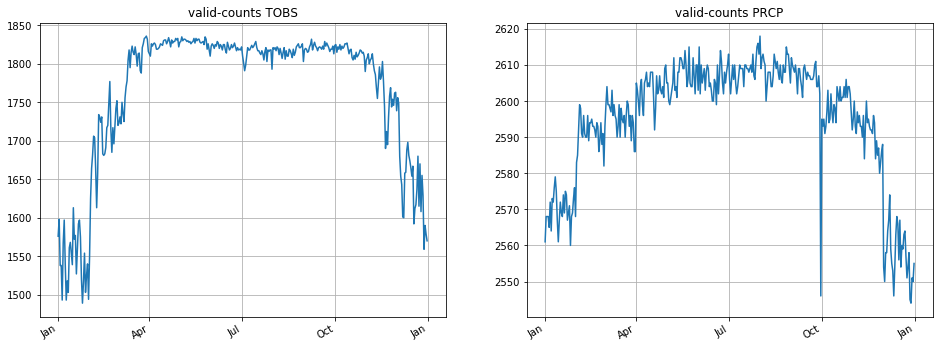

In [6]:
plot_pair(['TOBS','PRCP'],plot_valid)

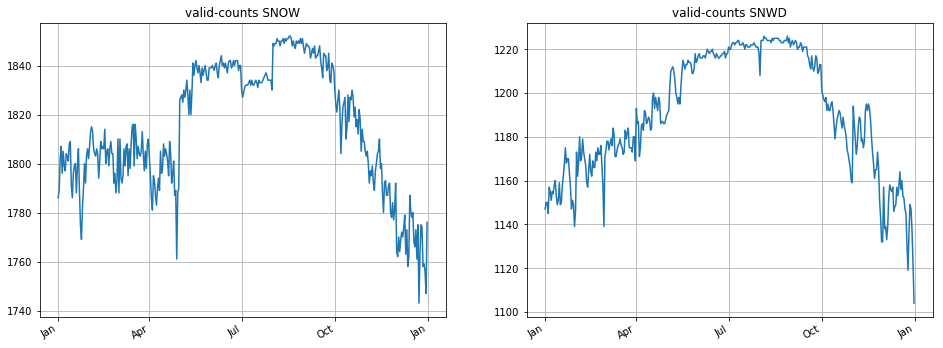

In [7]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean'] / 10
    std=np.sqrt(STAT[m]['Var']) / 10
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

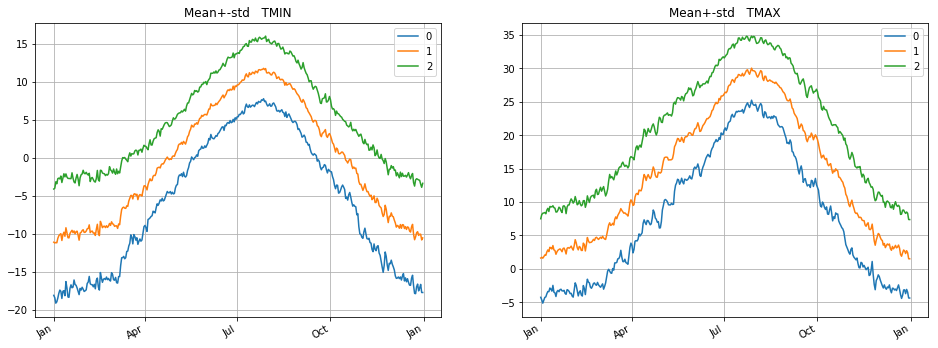

In [9]:
b = plot_pair(['TMIN','TMAX'],plot_mean_std)

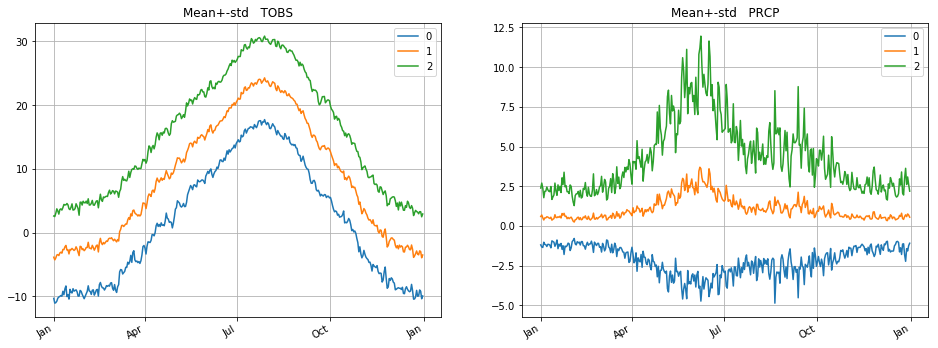

In [10]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

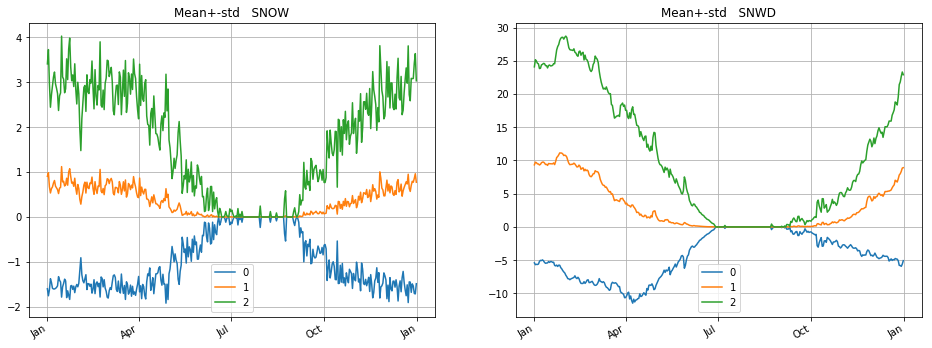

In [11]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [12]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

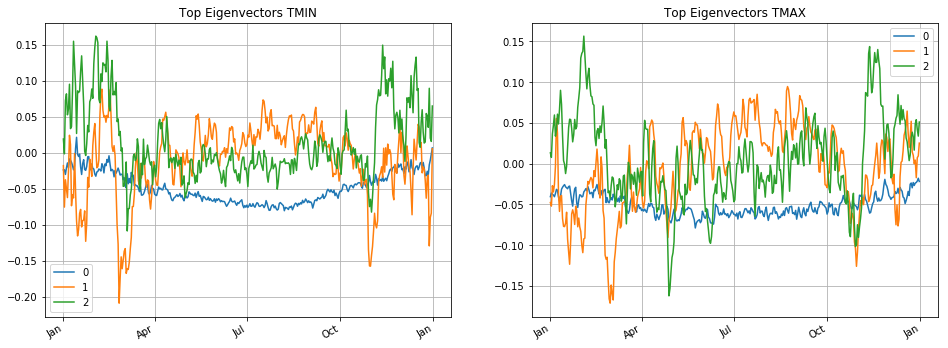

In [13]:
plot_pair(['TMIN','TMAX'],plot_eigen)

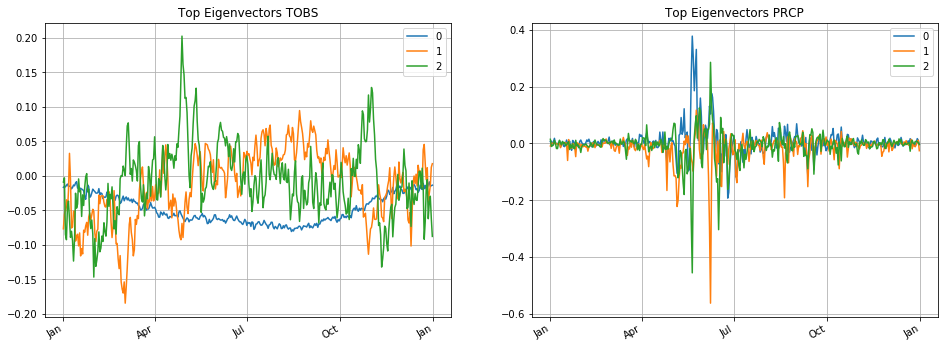

In [14]:
plot_pair(['TOBS','PRCP'],plot_eigen)

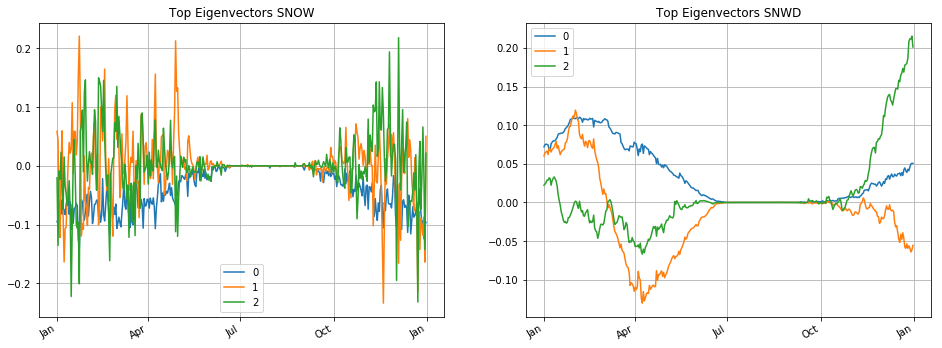

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [16]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

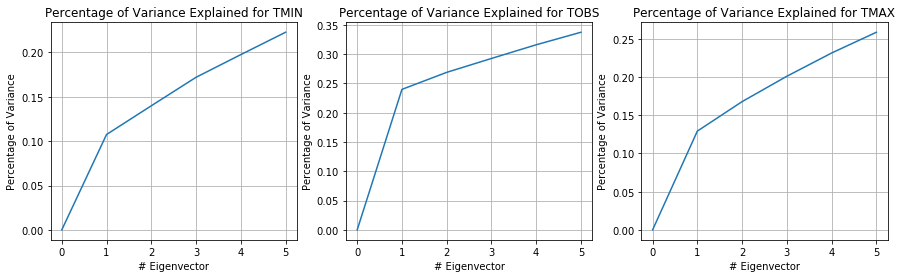

In [17]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

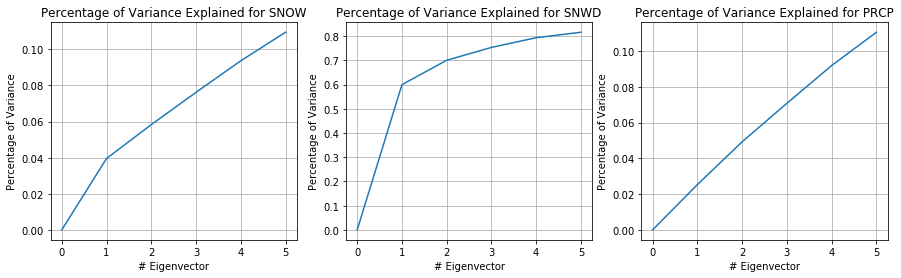

In [18]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00243013'
92 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    954.9| 46.8511|-108.3133|       TOBS|USC00243013|    20|[80 49 00 C6 30 5...|1915.0|SBBBSBSS|
|    954.9| 46.8511|-108.3133|       TOBS|USC00243013|    39|[F0 D6 58 D8 38 D...|1916.0|SBBBSBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

slope is :0.345850896999
SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00243013'
92 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   l

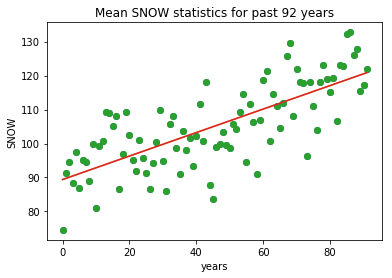

In [12]:
from scipy import stats
def return_temp_data(measurement):

    Query_temp = "SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00243013')
    print Query_temp
    df_T = sqlContext.sql(Query_temp)
    print df_T.count(),'rows'
    df_T.show(2)
    rows=df_T.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
    T_max = np.vstack(rows)
    return T_max

def plot_winter(T,measurement):
    winter_temp = []
    for temp in T:
        winter_temp.append(np.nanmean(temp))
    xi = np.arange(0,len(winter_temp))
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,winter_temp)
    line = slope*xi+intercept
    print "slope is :"+str(slope)
    plt.plot(xi,winter_temp,'o', xi, line)
    plt.title("Mean "+measurement+" statistics for past "+str(len(xi))+" years")
    plt.ylabel(measurement)
    plt.xlabel("years")

T_min = return_temp_data('TOBS')
plot_winter(T_min,'TOBS')

T_min = return_temp_data('SNOW')
plot_winter(T_min,'SNOW')

In [ ]:
#sc.stop()